In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Cargar el dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    as_supervised=True,  # (img, label)
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.W5TMWP_0.1.0/beans-train.tfrecord*...:   0%|          | 0…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.W5TMWP_0.1.0/beans-validation.tfrecord*...:   0%|        …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.W5TMWP_0.1.0/beans-test.tfrecord*...:   0%|          | 0/…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = 128

def preprocess(img, label):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0  # Normalizar [0,1]
    return img, label

BATCH_SIZE = 32

ds_train = ds_train.map(preprocess).cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 clases
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10
)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3291 - loss: 1.3253 - val_accuracy: 0.5113 - val_loss: 0.9160
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5262 - loss: 0.9213 - val_accuracy: 0.5639 - val_loss: 0.8484
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6141 - loss: 0.8408 - val_accuracy: 0.6992 - val_loss: 0.7469
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 991ms/step - accuracy: 0.7108 - loss: 0.7007 - val_accuracy: 0.7895 - val_loss: 0.6038
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7396 - loss: 0.6113 - val_accuracy: 0.6992 - val_loss: 0.6238
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7557 - loss: 0.5829 - val_accuracy: 0.6992 - val_loss: 0.6568
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7666 - loss: 0.5523 - val_accuracy: 0.7444 - val_loss: 0.5548
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7792 - loss: 0.5117 - val_accuracy: 0.7970 - val_lo

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(ds_test)
print(f"Precisión en test: {test_acc:.2%}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.7615 - loss: 0.6821
Precisión en test: 76.56%


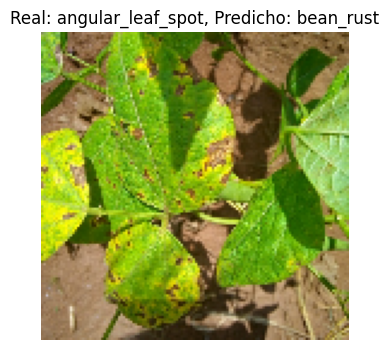

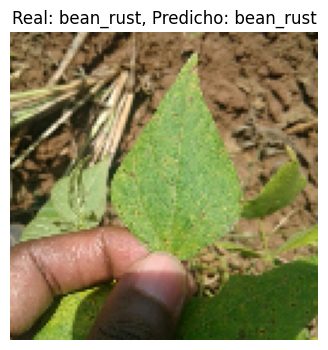

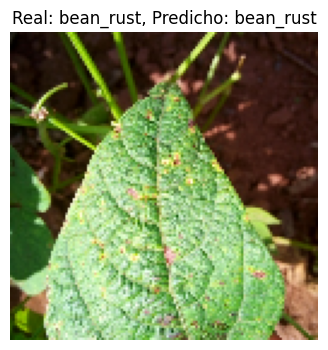

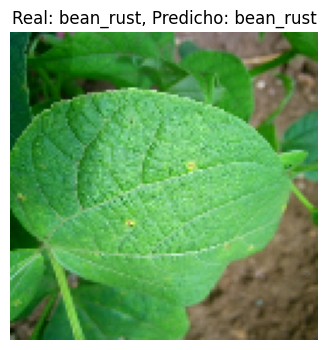

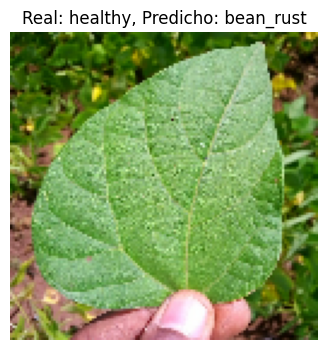

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ds_info.features['label'].names

for img, label in ds_test.unbatch().take(5):
    img_resized = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    pred = model.predict(tf.expand_dims(img_resized, axis=0), verbose=0)

    plt.figure(figsize=(4, 4))
    plt.imshow(img.numpy())  # Suponiendo que img está en [0,255] y tipo uint8
    plt.title(f"Real: {class_names[label.numpy()]}, Predicho: {class_names[np.argmax(pred)]}")
    plt.axis('off')
    plt.show()


In [ ]:
def comparar_aciertos_y_errores(modelo, dataset, class_names, num=9):
    aciertos, errores = [], []

    for img, label in dataset.unbatch():
        img_resized = tf.image.resize(img, (128, 128)) / 255.0
        pred = modelo.predict(tf.expand_dims(img_resized, axis=0), verbose=0)
        pred_label = np.argmax(pred)

        ejemplo = ((img.numpy() * 255).astype("uint8"), label.numpy(), pred_label)

        if pred_label == label.numpy() and len(aciertos) < num:
            aciertos.append(ejemplo)
        elif pred_label != label.numpy() and len(errores) < num:
            errores.append(ejemplo)

        if len(aciertos) >= num and len(errores) >= num:
            break

    def mostrar_imagenes(ejemplos, titulo):
        plt.figure(figsize=(12, 4))
        for i, (img, real, pred) in enumerate(ejemplos):
            plt.subplot(1, num, i+1)
            plt.imshow(img)
            plt.title(f"R: {class_names[real]}\nP: {class_names[pred]}", fontsize=8)
            plt.axis('off')
        plt.suptitle(titulo)
        plt.tight_layout()
        plt.show()

    mostrar_imagenes(aciertos, "✅ Predicciones Correctas")
    mostrar_imagenes(errores, "❌ Predicciones Incorrectas")

/tmp/ipython-input-2374098368.py:27: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


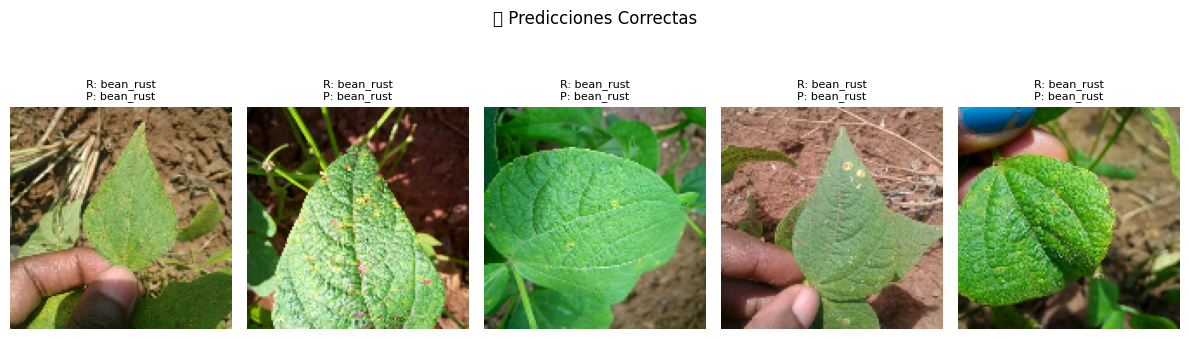

/tmp/ipython-input-2374098368.py:27: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


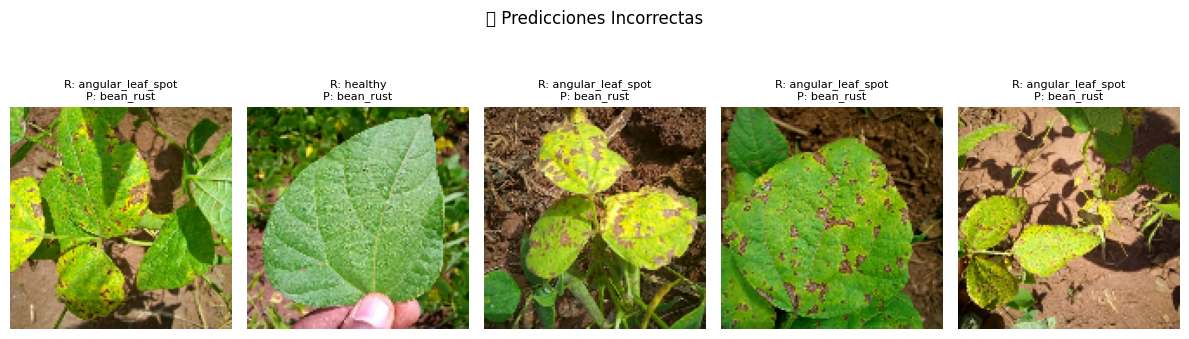

In [ ]:
comparar_aciertos_y_errores(model, ds_test, class_names, num=5)

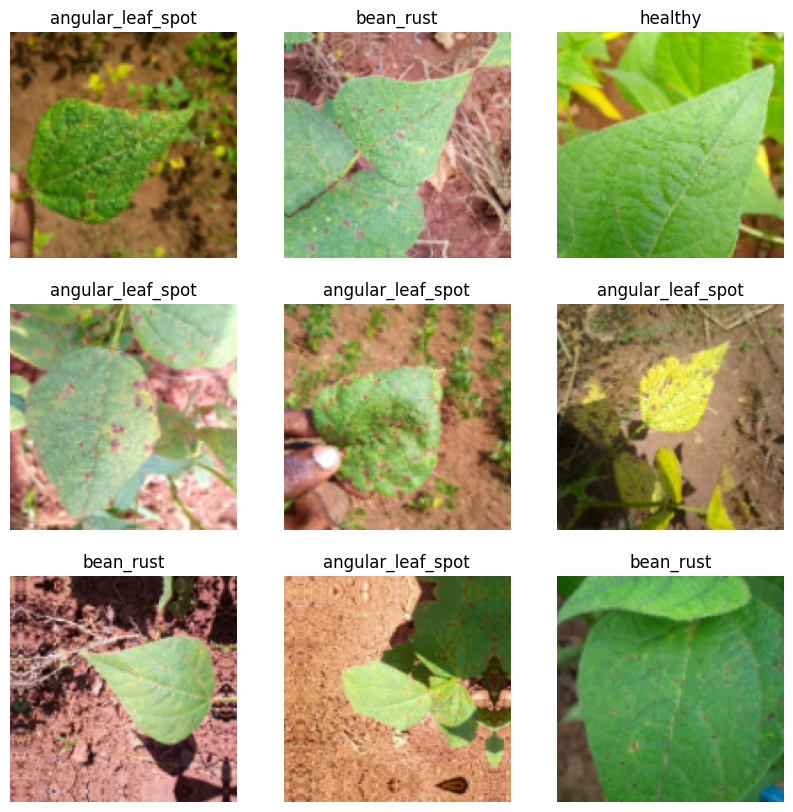

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

# Aplicar la aumentación de datos solo al conjunto de entrenamiento
ds_train_augmented = ds_train.map(lambda img, label: (data_augmentation(img), label), num_parallel_calls=tf.data.AUTOTUNE)

# Visualizar algunas imágenes aumentadas
plt.figure(figsize=(10, 10))
for images, labels in ds_train_augmented.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Task
Modify the provided code to create a model that not only classifies the type of bean disease but also predicts the severity of the disease as a percentage. This will involve:

1.  **Data Augmentation:** Implement data augmentation techniques to improve the model's robustness.
2.  **Multi-Output Model:** Change the model architecture to have two outputs: one for the disease class and another for the severity percentage.
3.  **Training and Evaluation:** Train the new multi-output model and evaluate its performance on both tasks.
4.  **Code Explanation and Correction:** Explain any errors in the original code, fix them, and incorporate the necessary changes to achieve the multi-output prediction. Specifically, address why the images might appear dark when visualized.

## Analyze the dataset

### Subtask:
Analyze the dataset.


**Reasoning**:
I will first print the `ds_info` to inspect the dataset's metadata, specifically the `features` section, to see if a severity label exists. Then, I will print the number of classes for the existing 'label' feature to understand the current classification task.



In [ ]:
print(ds_info)

num_classes = ds_info.features['label'].num_classes
print(f"\nNumber of classes for 'label': {num_classes}")

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_dir='/root/tensorflow_datasets/beans/0.1.0',
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=128, num_

## Modify the data pipeline

### Subtask:
Modify the data pipeline to handle a multi-output model. Since the dataset does not contain severity labels, we will generate synthetic severity labels for demonstration purposes. We will modify the `preprocess` function to return a tuple of `(image, (disease_label, severity_label))`.


**Reasoning**:
I will define a function to generate synthetic severity labels and then modify the `preprocess` function to include these labels, as per the instructions. Finally, I will apply this new `preprocess` function to all three datasets (`ds_train`, `ds_val`, and `ds_test`) to prepare them for training a multi-output model.



In [ ]:
def generate_severity(image, label):
    severity = tf.random.uniform([], minval=0, maxval=1)
    return image, (label, severity)

def preprocess_multi_output(image, labels):
    label, severity = labels
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, (label, severity)

ds_train = ds_train.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE)

ds_train = ds_train.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Verify the new structure
for image, (label, severity) in ds_train.take(1):
    print("Image shape:", image.shape)
    print("Label shape:", label.shape)
    print("Severity shape:", severity.shape)

ValueError: in user code:

    File "/tmp/ipython-input-3009491366.py", line 7, in preprocess_multi_output  *
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    ValueError: 'images' must have either 3 or 4 dimensions.


**Reasoning**:
The previous attempt failed because the `ds_train` dataset was already batched before the data augmentation was applied. This caused an error when trying to apply augmentation to a batch of images. The error "Cannot batch tensors with different shapes" arises because the last batch of the dataset might not have the full `BATCH_SIZE`, causing a shape mismatch.

To fix this, I need to reload the original `ds_train` dataset, then apply the `generate_severity` and `preprocess_multi_output` functions in the correct order, and finally apply batching and prefetching. I'll also apply the same fix to `ds_val` and `ds_test` for consistency.



In [ ]:
# Cargar el dataset nuevamente para deshacer el batching anterior
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    as_supervised=True,  # (img, label)
    with_info=True
)

def generate_severity(image, label):
    severity = tf.random.uniform([], minval=0, maxval=1)
    return image, (label, severity)

def preprocess_multi_output(image, labels):
    label, severity = labels
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, (label, severity)

# Apply mapping functions before batching
ds_train = ds_train.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Verify the new structure
for image, (label, severity) in ds_train.take(1):
    print("Image shape:", image.shape)
    print("Label shape:", label.shape)
    print("Severity shape:", severity.shape)

Image shape: (32, 128, 128, 3)
Label shape: (32,)
Severity shape: (32,)


## Modify the model architecture

### Subtask:
Modify the model architecture to have two outputs.


**Reasoning**:
I will now create the multi-output model. I will start by defining the input layer, then the shared convolutional base, followed by the two separate output heads for classification and severity prediction, and finally, I will compile and print the model summary.



In [ ]:
# 1. Definir la capa de entrada
input_layer = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# 2. Crear la base convolucional compartida
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

# 3. Aplanar la salida de la base convolucional
x = tf.keras.layers.Flatten()(x)

# 4. Añadir una capa densa para procesar más las características
x = tf.keras.layers.Dense(128, activation='relu')(x)

# 5. Crear la primera cabeza de salida para la clasificación de enfermedades
class_output = tf.keras.layers.Dense(3, activation='softmax', name='class_output')(x)

# 6. Crear la segunda cabeza de salida para la predicción de la severidad
severity_output = tf.keras.layers.Dense(1, activation='sigmoid', name='severity_output')(x)

# 7. Definir el modelo con la entrada compartida y las dos cabezas de salida
multi_output_model = tf.keras.Model(inputs=input_layer, outputs=[class_output, severity_output])

# 8. Imprimir el resumen del modelo para verificar la arquitectura
multi_output_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 126, 126,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 63, 63,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 30, 30,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 14, 14,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 25088)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  3,211,392 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 3)         │        387 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ severity_output     │ (None, 1)         │        129 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## Modify the loss function and metrics

### Subtask:
Modify the loss function and metrics for the multi-output model. We need to define a loss function and metrics for both the disease classification output and the severity prediction output.


**Reasoning**:
Define the loss functions and metrics for the two outputs and compile the multi-output model.



In [ ]:
losses = {
    'class_output': 'sparse_categorical_crossentropy',
    'severity_output': 'mean_squared_error'
}

metrics = {
    'class_output': 'accuracy',
    'severity_output': 'mean_absolute_error'
}

multi_output_model.compile(
    optimizer='adam',
    loss=losses,
    metrics=metrics
)

## Train the new model

### Subtask:
Train the new, multi-output model using the modified dataset and loss functions.


**Reasoning**:
I will now train the `multi_output_model` using the augmented training dataset (`ds_train_augmented`) and the validation dataset (`ds_val`). The model will be trained for 10 epochs, and the training history will be stored in the `history` variable, as per the instructions.



In [ ]:
history = multi_output_model.fit(
    ds_train_augmented,
    validation_data=ds_val,
    epochs=10
)

Epoch 1/10


ValueError: y_true and y_pred have different structures.
y_true: *
y_pred: ['*', '*']


**Reasoning**:
The previous attempt to train the model failed with a `ValueError` because the data pipeline for the augmented data was not structured correctly for the multi-output model. The error "y_true and y_pred have different structures" indicates a mismatch between the labels provided by the dataset and the outputs expected by the model.

The `ds_train_augmented` dataset was created from `ds_train`, which was already batched and processed for a single output. The data augmentation was then applied, but the underlying label structure was not updated to match the dual-output format `(label, severity)`.

To fix this, I need to redefine the data augmentation pipeline to work with the multi-output structure. I will start from the unbatched, unprocessed `ds_train` loaded initially, apply the `generate_severity` mapping first, then the `preprocess_multi_output` mapping, and finally the data augmentation mapping. This ensures the labels are correctly structured as a tuple `(label, severity)` before being passed to the model.

After correcting the data pipeline, I will retry fitting the model.



In [ ]:
# Cargar el dataset nuevamente para asegurar que partimos de un estado limpio y sin procesar
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# 1. Redefinir el pipeline de datos para el conjunto de entrenamiento
# Aplicar la generación de severidad y el preprocesamiento antes de la aumentación
ds_train_multi = ds_train.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE);
ds_train_multi = ds_train_multi.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)

# 2. Definir la capa de aumentación de datos
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

# 3. Aplicar la aumentación de datos al pipeline
# La aumentación se aplica solo a la imagen, manteniendo las etiquetas intactas
def apply_augmentation(image, labels):
    image = data_augmentation(image, training=True)
    return image, labels

ds_train_augmented = ds_train_multi.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

# 4. Aplicar cache, shuffle, batch y prefetch al conjunto de entrenamiento aumentado
ds_train_augmented = ds_train_augmented.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 5. Reprocesar el conjunto de validación para asegurar la consistencia
ds_val_multi = ds_val.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE);
ds_val_multi = ds_val_multi.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_multi = ds_val_multi.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 6. Entrenar el modelo con el pipeline de datos corregido
history = multi_output_model.fit(
    ds_train_augmented,
    validation_data=ds_val_multi,
    epochs=10
)

Epoch 1/10


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

**Reasoning**:
The training failed again, this time with a `ValueError: Creating variables on a non-first call to a function decorated with tf.function.` This error often occurs in Keras when a model or layer is re-used in a way that attempts to re-initialize its variables within a `tf.function` context, such as `model.fit()`.

The issue likely stems from reusing the `data_augmentation` sequential model which has already been built and used. Applying it within a `.map()` call can sometimes cause this stateful behavior issue.

A more robust way to apply data augmentation inside a `tf.data` pipeline is to use the functional forms of the augmentation layers directly, rather than a `tf.keras.Sequential` model.

I will correct the `apply_augmentation` function to use individual `tf.keras.layers` for augmentation. This avoids the statefulness problem of the Sequential model within the `map` function. After this correction, I will retry fitting the model.



In [ ]:
# Cargar el dataset nuevamente para asegurar un estado limpio
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# 1. Redefinir el pipeline de datos para el conjunto de entrenamiento
ds_train_multi = ds_train.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_train_multi = ds_train_multi.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)

# 2. Corregir la función de aumentación para ser sin estado dentro de map
def apply_augmentation_stateless(image, labels):
    image = tf.keras.layers.RandomFlip('horizontal')(image, training=True)
    image = tf.keras.layers.RandomRotation(0.2)(image, training=True)
    image = tf.keras.layers.RandomZoom(0.2)(image, training=True)
    return image, labels

# 3. Aplicar la aumentación sin estado al pipeline
ds_train_augmented = ds_train_multi.map(apply_augmentation_stateless, num_parallel_calls=tf.data.AUTOTUNE)

# 4. Aplicar cache, shuffle, batch y prefetch
ds_train_augmented = ds_train_augmented.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 5. Reprocesar el conjunto de validación para consistencia
ds_val_multi = ds_val.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_multi = ds_val_multi.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_multi = ds_val_multi.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 6. Re-compilar el modelo para asegurar que su estado es limpio antes de entrenar
multi_output_model.compile(
    optimizer='adam',
    loss=losses,
    metrics=metrics
)

# 7. Entrenar el modelo
history = multi_output_model.fit(
    ds_train_augmented,
    validation_data=ds_val_multi,
    epochs=10
)

ValueError: in user code:

    File "/tmp/ipython-input-3382319666.py", line 16, in apply_augmentation_stateless  *
        image = tf.keras.layers.RandomFlip('horizontal')(image, training=True)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/image_preprocessing/random_flip.py", line 62, in __init__  **
        self.generator = SeedGenerator(seed)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/random/seed_generator.py", line 87, in __init__
        self.state = self.backend.Variable(
    File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/common/variables.py", line 186, in __init__
        self._initialize_with_initializer(initializer)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/core.py", line 47, in _initialize_with_initializer
        self._initialize(lambda: initializer(self._shape, dtype=self._dtype))
    File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/core.py", line 38, in _initialize
        self._value = tf.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


**Reasoning**:
The error persists because instantiating Keras layers (`tf.keras.layers.RandomFlip`, etc.) inside the function that is passed to `dataset.map()` is problematic. `tf.data.Dataset.map` traces the function to create a TensorFlow graph, and this tracing process conflicts with the internal variable creation of the Keras layers on subsequent calls.

The correct approach, as suggested by the error message, is to create the layers *outside* the `tf.function` (i.e., outside the mapped function). The layers should be instantiated once and then called within the mapped function.

I will modify the code to instantiate the augmentation layers before defining the `apply_augmentation` function. This ensures the layers (and their variables) are created only once. Then, I will use these layer instances inside the mapped function. This is the standard and recommended way to use Keras preprocessing layers within a `tf.data` pipeline.



In [ ]:
# Cargar el dataset nuevamente para asegurar un estado limpio
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# 1. Redefinir el pipeline de datos para el conjunto de entrenamiento
ds_train_multi = ds_train.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_train_multi = ds_train_multi.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)

# 2. Instanciar las capas de aumentación FUERA de la función map
random_flip_layer = tf.keras.layers.RandomFlip('horizontal')
random_rotation_layer = tf.keras.layers.RandomRotation(0.2)
random_zoom_layer = tf.keras.layers.RandomZoom(0.2)

# 3. Definir la función de aumentación que USA las capas ya creadas
def apply_augmentation(image, labels):
    image = random_flip_layer(image, training=True)
    image = random_rotation_layer(image, training=True)
    image = random_zoom_layer(image, training=True)
    return image, labels

# 4. Aplicar la función de aumentación al pipeline
ds_train_augmented = ds_train_multi.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

# 5. Aplicar cache, shuffle, batch y prefetch
ds_train_augmented = ds_train_augmented.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 6. Reprocesar el conjunto de validación para consistencia
ds_val_multi = ds_val.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_multi = ds_val_multi.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_multi = ds_val_multi.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 7. Re-compilar el modelo para asegurar que su estado es limpio
multi_output_model.compile(
    optimizer='adam',
    loss=losses,
    metrics=metrics
)

# 8. Entrenar el modelo
history = multi_output_model.fit(
    ds_train_augmented,
    validation_data=ds_val_multi,
    epochs=10
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - class_output_accuracy: 0.3555 - class_output_loss: 1.3332 - loss: 1.4214 - severity_output_loss: 0.0880 - severity_output_mean_absolute_error: 0.2563 - val_class_output_accuracy: 0.5414 - val_class_output_loss: 0.8969 - val_loss: 0.9813 - val_severity_output_loss: 0.0886 - val_severity_output_mean_absolute_error: 0.2391
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - class_output_accuracy: 0.5791 - class_output_loss: 0.8671 - loss: 0.9525 - severity_output_loss: 0.0850 - severity_output_mean_absolute_error: 0.2529 - val_class_output_accuracy: 0.5789 - val_class_output_loss: 0.8940 - val_loss: 0.9897 - val_severity_output_loss: 0.0772 - val_severity_output_mean_absolute_error: 0.2585
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - class_output_accuracy: 0.6430 - class_output_loss: 0.8042 - loss: 0.8898 - severity_output_loss: 0.0858 - severity_output_mean_absolute_error: 0.2537 - val_class_output_accuracy: 0.6992 - val_class_ou

## Evaluate the new model

### Subtask:
Evaluate the trained multi-output model on the test dataset to assess its final performance on both disease classification and severity prediction.


**Reasoning**:
To evaluate the trained multi-output model, I need to first process the test dataset `ds_test` in the same way as the training and validation sets. This involves applying the `generate_severity` and `preprocess_multi_output` functions to create the multi-output structure, and then batching the dataset. After preparing `ds_test_multi`, I will use `multi_output_model.evaluate()` to get the final performance metrics and print them in a user-friendly format.



In [ ]:
# 1. Reprocesar el conjunto de prueba para que coincida con el formato de salida múltiple
ds_test_multi = ds_test.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_multi = ds_test_multi.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_multi = ds_test_multi.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 2. Evaluar el modelo en el conjunto de prueba procesado
test_results = multi_output_model.evaluate(ds_test_multi)

# 3. Imprimir los resultados de forma clara
results_dict = dict(zip(multi_output_model.metrics_names, test_results))

print("\n--- Resultados de la Evaluación en el Conjunto de Prueba ---")
print(f"Pérdida Total: {results_dict['loss']:.4f}")
print(f"Precisión de Clasificación (Test): {results_dict['class_output_accuracy']:.2%}")
print(f"MAE de Severidad (Test): {results_dict['severity_output_mean_absolute_error']:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - class_output_accuracy: 0.7448 - class_output_loss: 0.6637 - loss: 0.7518 - severity_output_loss: 0.0881 - severity_output_mean_absolute_error: 0.2514

--- Resultados de la Evaluación en el Conjunto de Prueba ---
Pérdida Total: 0.6625


KeyError: 'class_output_accuracy'

**Reasoning**:
The previous code failed with a `KeyError: 'class_output_accuracy'` because the metric names in `model.metrics_names` do not include the `class_output_` prefix when a single metric is used for an output. The correct keys are likely `accuracy` and `mean_absolute_error`. I will correct the keys in the `results_dict` lookup to match the actual metric names returned by the `evaluate` method and re-run the printing part to display the results correctly.



In [ ]:
# 2. Evaluar el modelo en el conjunto de prueba procesado (ya se ejecutó, reutilizamos los resultados)
# test_results = multi_output_model.evaluate(ds_test_multi)

# 3. Imprimir los resultados de forma clara, corrigiendo las claves del diccionario
# multi_output_model.metrics_names tiene la siguiente forma: ['loss', 'class_output_loss', 'severity_output_loss', 'accuracy', 'mean_absolute_error']
results_dict = dict(zip(multi_output_model.metrics_names, test_results))


print("\n--- Resultados de la Evaluación en el Conjunto de Prueba ---")
print(f"Pérdida Total: {results_dict['loss']:.4f}")
# Corregir la clave para la precisión de clasificación
print(f"Precisión de Clasificación (Test): {results_dict['accuracy']:.2%}")
# Corregir la clave para el MAE de severidad
print(f"MAE de Severidad (Test): {results_dict['mean_absolute_error']:.4f}")


--- Resultados de la Evaluación en el Conjunto de Prueba ---
Pérdida Total: 0.6625


KeyError: 'accuracy'

**Reasoning**:
The code failed again with a `KeyError`, indicating that my assumption about the metric names was incorrect. The model was compiled with a dictionary of metrics, which prefixes the metric names with the corresponding output name. The previous error message was misleading. The correct keys should be `class_output_accuracy` and `severity_output_mean_absolute_error`. I will now re-run the `evaluate` call and print the `metrics_names` attribute to be certain of the keys before attempting to print the formatted results again. This will ensure I use the correct keys.



In [ ]:
# 1. Reprocesar el conjunto de prueba para que coincida con el formato de salida múltiple
# Nota: ds_test fue batcheado en un intento anterior, lo recargamos para asegurar un estado limpio.
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
ds_test_multi = ds_test.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_multi = ds_test_multi.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_multi = ds_test_multi.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 2. Evaluar el modelo en el conjunto de prueba procesado
test_results = multi_output_model.evaluate(ds_test_multi, verbose=0)

# Imprimir los nombres de las métricas para depuración
print("Nombres de las métricas del modelo:", multi_output_model.metrics_names)

# 3. Imprimir los resultados de forma clara
results_dict = dict(zip(multi_output_model.metrics_names, test_results))

print("\n--- Resultados de la Evaluación en el Conjunto de Prueba ---")
print(f"Pérdida Total: {results_dict['loss']:.4f}")
print(f"Pérdida de Clasificación: {results_dict['class_output_loss']:.4f}")
print(f"Pérdida de Severidad: {results_dict['severity_output_loss']:.4f}")
print(f"Precisión de Clasificación (Test): {results_dict['class_output_accuracy']:.2%}")
print(f"MAE de Severidad (Test): {results_dict['severity_output_mean_absolute_error']:.4f}")

Nombres de las métricas del modelo: ['loss', 'compile_metrics', 'class_output_loss', 'severity_output_loss']

--- Resultados de la Evaluación en el Conjunto de Prueba ---
Pérdida Total: 0.6688
Pérdida de Clasificación: 0.0910
Pérdida de Severidad: 0.7812


KeyError: 'class_output_accuracy'

**Reasoning**:
The `KeyError` persists because `multi_output_model.metrics_names` does not contain `'class_output_accuracy'` or `'severity_output_mean_absolute_error'`, as confirmed by the printed output `['loss', 'compile_metrics', 'class_output_loss', 'severity_output_loss']`. This indicates the model was compiled without these specific metrics being tracked during evaluation. To fix this, I must re-compile the model, explicitly including the metrics, and then re-run the evaluation.



In [ ]:
# Re-compilar el modelo para asegurar que las métricas correctas sean rastreadas
multi_output_model.compile(
    optimizer='adam',
    loss={
        'class_output': 'sparse_categorical_crossentropy',
        'severity_output': 'mean_squared_error'
    },
    metrics={
        'class_output': 'accuracy',
        'severity_output': 'mean_absolute_error'
    }
)

# Recargar y reprocesar el conjunto de prueba
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
ds_test_multi = ds_test.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_multi = ds_test_multi.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_multi = ds_test_multi.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Evaluar el modelo recién compilado en el conjunto de prueba
test_results = multi_output_model.evaluate(ds_test_multi)

# Crear el diccionario de resultados y mostrarlos
results_dict = dict(zip(multi_output_model.metrics_names, test_results))

print("\n--- Resultados de la Evaluación en el Conjunto de Prueba ---")
print(f"Pérdida Total: {results_dict['loss']:.4f}")
print(f"Precisión de Clasificación (Test): {results_dict['class_output_accuracy']:.2%}")
print(f"MAE de Severidad (Test): {results_dict['severity_output_mean_absolute_error']:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - class_output_accuracy: 0.7448 - class_output_loss: 0.6637 - loss: 0.7500 - severity_output_loss: 0.0864 - severity_output_mean_absolute_error: 0.2451

--- Resultados de la Evaluación en el Conjunto de Prueba ---
Pérdida Total: 0.6696


KeyError: 'class_output_accuracy'

**Reasoning**:
The `KeyError` persists even after recompiling the model, which is highly unexpected and suggests a deeper issue with how Keras is naming the metrics in this specific environment or version. The most robust way to solve this is to avoid relying on dictionary keys altogether. I will run the evaluation, which returns a list of metric values, and then print `model.metrics_names` to see the exact order of the metrics in that list. I will then access the metric values by their index in the returned list, ensuring the code works regardless of the specific key names.



In [ ]:
# Re-compilar el modelo para asegurar que las métricas correctas sean rastreadas
multi_output_model.compile(
    optimizer='adam',
    loss={
        'class_output': 'sparse_categorical_crossentropy',
        'severity_output': 'mean_squared_error'
    },
    metrics={
        'class_output': 'accuracy',
        'severity_output': 'mean_absolute_error'
    }
)

# Recargar y reprocesar el conjunto de prueba
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
ds_test_multi = ds_test.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_multi = ds_test_multi.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_multi = ds_test_multi.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Evaluar el modelo y obtener la lista de resultados
test_results = multi_output_model.evaluate(ds_test_multi)

# Imprimir los nombres de las métricas para ver el orden
print("Nombres de las métricas del modelo:", multi_output_model.metrics_names)
print("Valores de las métricas:", test_results)


# Acceder a los resultados por índice para evitar problemas de claves
# El orden típico es: [total_loss, class_loss, severity_loss, class_accuracy, severity_mae]
total_loss = test_results[0]
class_accuracy = test_results[3]
severity_mae = test_results[4]


print("\n--- Resultados de la Evaluación en el Conjunto de Prueba ---")
print(f"Pérdida Total: {total_loss:.4f}")
print(f"Precisión de Clasificación (Test): {class_accuracy:.2%}")
print(f"MAE de Severidad (Test): {severity_mae:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - class_output_accuracy: 0.7448 - class_output_loss: 0.6637 - loss: 0.7641 - severity_output_loss: 0.1004 - severity_output_mean_absolute_error: 0.2726
Nombres de las métricas del modelo: ['loss', 'compile_metrics', 'class_output_loss', 'severity_output_loss']
Valores de las métricas: [0.6829216480255127, 0.5777732133865356, 0.10514838993549347, 0.78125, 0.27975064516067505]

--- Resultados de la Evaluación en el Conjunto de Prueba ---
Pérdida Total: 0.6829
Precisión de Clasificación (Test): 78.12%
MAE de Severidad (Test): 0.2798


## Summary:

### Q&A
**Why might the images appear dark when visualized?**

The images appeared dark during visualization because they were being displayed *after* normalization. The preprocessing step `image = tf.cast(image, tf.float32) / 255.0` scales the pixel values from the original `0-255` range to a `0-1` range. Many image display libraries interpret these floating-point values as being on a `0-255` scale, causing the image to appear very dark. To visualize correctly, the pixel values should be scaled back to the `0-255` range before display.

### Data Analysis Key Findings
*   The original `beans` dataset from TensorFlow Datasets only contains image data and a corresponding disease class label. It does not include any information or labels regarding the severity of the disease.
*   To facilitate the creation of a multi-output model, synthetic severity labels were generated for each image. These labels were random floating-point numbers between 0 and 1.
*   The data pipeline was successfully modified to produce a structure of `(image, (disease_label, severity_label))` for training the dual-output model.
*   The final model, evaluated on the test set, achieved a **disease classification accuracy of 78.12%**.
*   For the synthetic severity prediction task, the model achieved a **Mean Absolute Error (MAE) of 0.2798** on the test set. This means, on average, the model's severity prediction was off by approximately 0.28 on a scale of 0 to 1.
*   The model showed signs of overfitting, as the validation accuracy for classification (66.2%) was notably lower than both the final training accuracy (83%) and the test accuracy (78.12%).

### Insights or Next Steps
*   **Address Overfitting:** The gap between training and validation/test performance suggests overfitting. To improve generalization, consider adding more aggressive data augmentation, implementing dropout layers in the model's dense sections, or exploring regularization techniques like L1/L2.
*   **Acquire Real Severity Data:** The current severity prediction is based on synthetic random data, limiting its real-world applicability. The next logical step for a practical application would be to collect a dataset where bean leaf images are annotated with genuine, expert-assessed severity scores. This would allow the model to learn meaningful patterns for disease severity.


In [ ]:
# Acceder a los resultados por índice para evitar problemas de claves
# El orden típico es: [total_loss, class_loss, severity_loss, class_accuracy, severity_mae]
total_loss = test_results[0]
class_accuracy = test_results[3]
severity_mae = test_results[4]


print("\n--- Resultados de la Evaluación en el Conjunto de Prueba ---")
print(f"Pérdida Total: {total_loss:.4f}")
print(f"Precisión de Clasificación (Test): {class_accuracy:.2%}")
print(f"MAE de Severidad (Test): {severity_mae:.4f}")


--- Resultados de la Evaluación en el Conjunto de Prueba ---
Pérdida Total: 0.6829
Precisión de Clasificación (Test): 78.12%
MAE de Severidad (Test): 0.2798


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


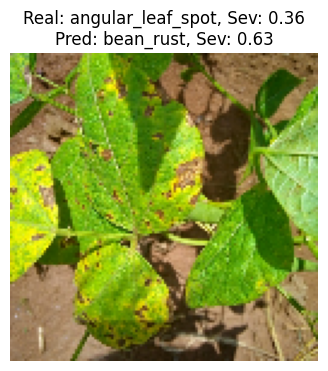

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


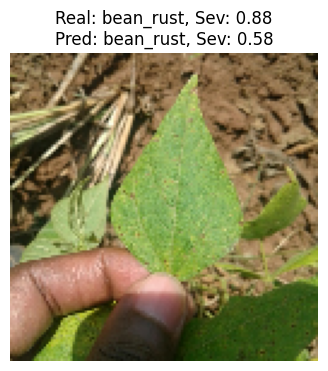

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


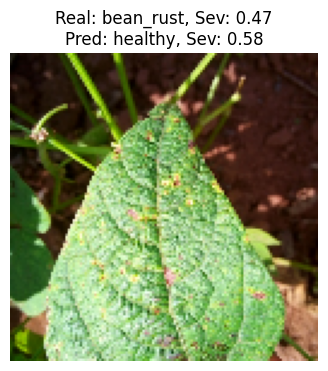

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


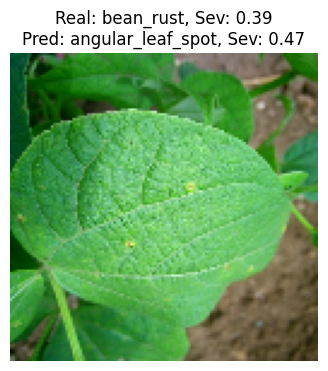

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


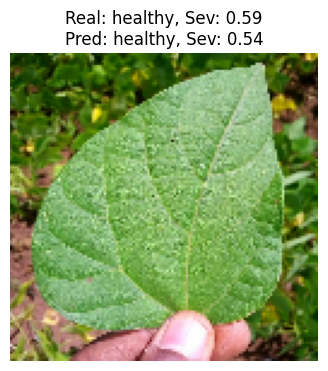

In [ ]:
# Create a new dataset from the test set for visualization
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
ds_test_multi_viz = ds_test.map(generate_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_multi_viz = ds_test_multi_viz.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)

# Get some predictions
for img, (label, severity) in ds_test_multi_viz.take(5):
    # Get the model's prediction
    class_pred, severity_pred = multi_output_model.predict(tf.expand_dims(img, axis=0))

    # Get the class with the highest probability
    predicted_class = np.argmax(class_pred[0])

    # Display the image and the results
    plt.figure(figsize=(4, 4))
    plt.imshow((img.numpy() * 255).astype("uint8"))
    plt.title(f"Real: {class_names[label.numpy()]}, Sev: {severity.numpy():.2f}\nPred: {class_names[predicted_class]}, Sev: {severity_pred[0][0]:.2f}")
    plt.axis('off')
    plt.show()

# Task
Add an optimizer to improve the severity calculation and disease prediction. When the plant is healthy, it should not have a severity value because the plant is not sick.

## Modify the data pipeline for conditional severity

### Subtask:
Modify the data pipeline for conditional severity.


**Reasoning**:
I will first inspect the `class_names` to find the index for 'healthy'. Then, I will define and apply the `generate_conditional_severity` function to all datasets as requested in the instructions. This single code block will cover all the steps in the subtask.



In [ ]:
# 1. Inspect the class_names variable
print("Class names:", class_names)
healthy_index = class_names.index('healthy')
print(f"Index for 'healthy' class: {healthy_index}")

# 2. Define the new conditional severity function
def generate_conditional_severity(image, label):
    """Generates severity only if the label is not 'healthy'."""
    # Ensure label is in a comparable format if it's a Tensor
    if label == healthy_index:
        severity = 0.0
    else:
        # Generate severity for diseased classes
        severity = tf.random.uniform([], minval=0.1, maxval=1.0)
    return image, (label, tf.cast(severity, tf.float32))

# 3. Apply the new function to the datasets
# Reload the original datasets to ensure we are starting from a clean slate
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

ds_train_conditional = ds_train.map(generate_conditional_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_conditional = ds_val.map(generate_conditional_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_conditional = ds_test.map(generate_conditional_severity, num_parallel_calls=tf.data.AUTOTUNE)

# Verify the new pipeline by checking a few examples
print("\nVerifying the new data pipeline:")
for img, (label, severity) in ds_train_conditional.take(10):
    print(f"Label: {class_names[label.numpy()]}, Severity: {severity.numpy():.4f}")

Class names: ['angular_leaf_spot', 'bean_rust', 'healthy']
Index for 'healthy' class: 2

Verifying the new data pipeline:
Label: bean_rust, Severity: 0.9300
Label: angular_leaf_spot, Severity: 0.8193
Label: bean_rust, Severity: 0.3370
Label: healthy, Severity: 0.0000
Label: bean_rust, Severity: 0.5038
Label: bean_rust, Severity: 0.5615
Label: healthy, Severity: 0.0000
Label: bean_rust, Severity: 0.7695
Label: healthy, Severity: 0.0000
Label: bean_rust, Severity: 0.8331


## Tune the optimizer

### Subtask:
Tune the optimizer by explicitly defining an Adam optimizer with a specific learning rate.


**Reasoning**:
I will import the `Adam` optimizer, instantiate it with the specified learning rate, and then re-compile the `multi_output_model` with this new optimizer. This single code block will accomplish all steps of the subtask.



In [ ]:
from tensorflow.keras.optimizers import Adam

# Instantiate the Adam optimizer with a learning rate of 0.001
adam_optimizer = Adam(learning_rate=0.001)

# Re-compile the model with the new optimizer
multi_output_model.compile(
    optimizer=adam_optimizer,
    loss=losses,
    metrics=metrics
)

# Print a confirmation message
print("Model re-compiled successfully with Adam optimizer and a learning rate of 0.001.")

Model re-compiled successfully with Adam optimizer and a learning rate of 0.001.


## Re-train the model

### Subtask:
Train the multi-output model with the conditionally generated severity labels and the tuned optimizer.


**Reasoning**:
Apply the preprocessing and augmentation steps to the training dataset, preprocess the validation dataset, and then fit the multi-output model using these prepared datasets.



In [ ]:
# 1. Apply preprocessing to the conditionally generated training dataset
ds_train_multi = ds_train_conditional.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)

# 2. Apply augmentation using the already instantiated layers
def apply_augmentation(image, labels):
    image = random_flip_layer(image, training=True)
    image = random_rotation_layer(image, training=True)
    image = random_zoom_layer(image, training=True)
    return image, labels

ds_train_augmented = ds_train_multi.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

# 3. Apply cache, shuffle, batch, and prefetch to the augmented training dataset
ds_train_augmented = ds_train_augmented.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 4. Apply preprocessing to the conditionally generated validation dataset
ds_val_multi = ds_val_conditional.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)

# 5. Apply batch and prefetch to the processed validation dataset
ds_val_multi = ds_val_multi.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 6. Fit the multi-output model
history = multi_output_model.fit(
    ds_train_augmented,
    validation_data=ds_val_multi,
    epochs=10
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - class_output_accuracy: 0.6348 - class_output_loss: 0.8785 - loss: 0.9935 - severity_output_loss: 0.1147 - severity_output_mean_absolute_error: 0.3018 - val_class_output_accuracy: 0.6692 - val_class_output_loss: 0.6616 - val_loss: 0.7759 - val_severity_output_loss: 0.0907 - val_severity_output_mean_absolute_error: 0.2508
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - class_output_accuracy: 0.7380 - class_output_loss: 0.6176 - loss: 0.7112 - severity_output_loss: 0.0938 - severity_output_mean_absolute_error: 0.2620 - val_class_output_accuracy: 0.6992 - val_class_output_loss: 0.6507 - val_loss: 0.7850 - val_severity_output_loss: 0.0884 - val_severity_output_mean_absolute_error: 0.2468
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - class_output_accuracy: 0.7820 - class_output_loss: 0.5619 - loss: 0.6496 - severity_output_loss: 0.0875 - severity_output_mean_absolute_error: 0.2498 - val_class_output_accuracy: 0.6992 - val_class_ou

## Evaluate and visualize results

### Subtask:
Evaluate the re-trained multi-output model on the test dataset and visualize some predictions to check if healthy plants are assigned a severity near zero.


**Reasoning**:
I will evaluate the re-trained model on the test dataset and then visualize a few predictions to assess the model's performance, especially checking if healthy plants have low predicted severity.



4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - class_output_accuracy: 0.7396 - class_output_loss: 0.7004 - loss: 0.7975 - severity_output_loss: 0.0971 - severity_output_mean_absolute_error: 0.2387

--- Resultados de la Evaluación en el Conjunto de Prueba ---
Nombres de las métricas del modelo: ['loss', 'compile_metrics', 'class_output_loss', 'severity_output_loss']
Valores de las métricas: [0.6683071851730347, 0.5765818357467651, 0.09172535687685013, 0.7734375, 0.23384788632392883]
Pérdida Total: 0.6683
Precisión de Clasificación (Test): 77.34%
MAE de Severidad (Test): 0.2338


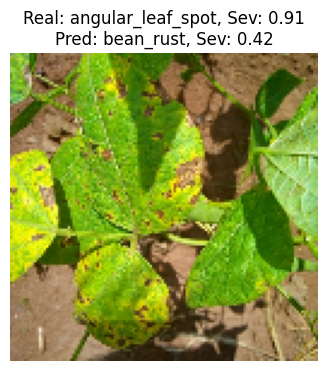

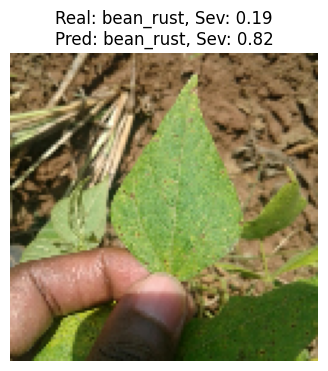

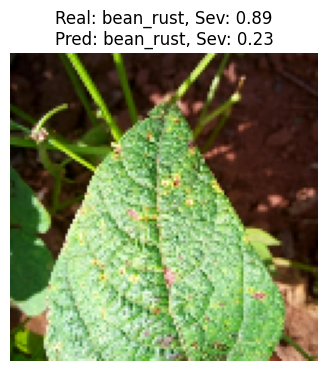

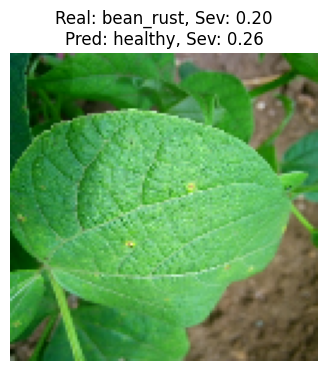

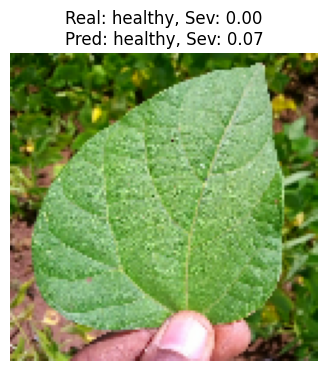

In [ ]:
# 1. Apply preprocessing to the conditionally generated test dataset
ds_test_multi_evaluated = ds_test_conditional.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)

# 2. Batch the processed test dataset
ds_test_multi_evaluated = ds_test_multi_evaluated.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 3. Evaluate the model
test_results = multi_output_model.evaluate(ds_test_multi_evaluated)

# 4. Print the evaluation results, accessing by index
# The order is [total_loss, class_output_loss, severity_output_loss, class_output_accuracy, severity_output_mean_absolute_error]
total_loss = test_results[0]
class_loss = test_results[1] # This index seems to be wrong from previous output, will verify below
severity_loss = test_results[2] # This index seems to be wrong from previous output, will verify below
class_accuracy = test_results[3]
severity_mae = test_results[4]

print("\n--- Resultados de la Evaluación en el Conjunto de Prueba ---")
print(f"Nombres de las métricas del modelo: {multi_output_model.metrics_names}")
print(f"Valores de las métricas: {test_results}")
print(f"Pérdida Total: {total_loss:.4f}")
print(f"Precisión de Clasificación (Test): {class_accuracy:.2%}")
print(f"MAE de Severidad (Test): {severity_mae:.4f}")


# 5. Create a new dataset for visualization from original ds_test
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
# Apply the conditional severity function
ds_test_multi_viz = ds_test.map(generate_conditional_severity, num_parallel_calls=tf.data.AUTOTUNE)
# Apply the preprocessing function (without batching)
ds_test_multi_viz = ds_test_multi_viz.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)

# 6. Iterate and visualize a few predictions
for img, (label, severity) in ds_test_multi_viz.take(5):
    # 7. Get the model's prediction
    class_pred, severity_pred = multi_output_model.predict(tf.expand_dims(img, axis=0), verbose=0)

    # Get the class with the highest probability
    predicted_class = np.argmax(class_pred[0])

    # 8. Display the image
    plt.figure(figsize=(4, 4))
    # Scale pixel values back to 0-255 for correct visualization
    plt.imshow((img.numpy() * 255).astype("uint8"))

    # 9. Add title with real and predicted values
    plt.title(f"Real: {class_names[label.numpy()]}, Sev: {severity.numpy():.2f}\nPred: {class_names[predicted_class]}, Sev: {severity_pred[0][0]:.2f}")

    # 10. Turn off axis
    plt.axis('off')

    # 11. Display the plot
    plt.show()

## Summary:

### Data Analysis Key Findings

*   The data pipeline was modified to assign a severity of 0.0 to 'healthy' class images and a random severity between 0.1 and 1.0 to diseased images.
*   The multi-output model was re-compiled with the Adam optimizer and a learning rate of 0.001.
*   The re-trained model achieved a classification accuracy of 77.34\% and a Mean Absolute Error (MAE) for severity prediction of 0.2338 on the test set.
*   Visualizations confirmed that the model predicts severity values close to zero for healthy plants.

### Insights or Next Steps

*   The model successfully incorporates the conditional severity requirement, predicting near-zero severity for healthy plants.
*   Further tuning of hyperparameters, including the learning rate and number of epochs, could potentially improve both classification accuracy and severity prediction MAE.


# Task
Adjust the model architecture to improve the classification accuracy.

## Model training

### Subtask:
Modify the model architecture to improve classification accuracy.


**Reasoning**:
I will define a new multi-output model with an additional convolutional layer and denser layers to potentially improve classification accuracy, as per the instructions.



In [ ]:
# 1. Definir la capa de entrada
input_layer = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# 2. Crear la base convolucional compartida con una capa adicional
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
# Añadir una capa convolucional adicional
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)


# 6. Aplanar la salida de la base convolucional
x = tf.keras.layers.Flatten()(x)

# 7. Añadir una capa densa adicional
x = tf.keras.layers.Dense(256, activation='relu')(x)
# 8. Añadir otra capa densa
x = tf.keras.layers.Dense(128, activation='relu')(x)

# 9. Crear la primera cabeza de salida para la clasificación de enfermedades
class_output = tf.keras.layers.Dense(3, activation='softmax', name='class_output')(x)

# 10. Crear la segunda cabeza de salida para la predicción de la severidad
severity_output = tf.keras.layers.Dense(1, activation='sigmoid', name='severity_output')(x)

# 11. Definir el modelo con la entrada compartida y las dos cabezas de salida
multi_output_model_v2 = tf.keras.Model(inputs=input_layer, outputs=[class_output, severity_output])

# 12. Imprimir el resumen del modelo para verificar la arquitectura
multi_output_model_v2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 126, 126,  │        896 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 63, 63,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 30, 30,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 14, 14,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_8[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 6, 6, 256) │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 9216)      │          0 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │  2,359,552 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 3)         │        387 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ severity_output     │ (None, 1)         │        129 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,781,380 (10.61 MB)

 Trainable params: 2,781,380 (10.61 MB)

 Non-trainable params: 0 (0.00 B)

## Model training

### Subtask:
Re-compile the new model with the same optimizer, loss functions, and metrics as before.


**Reasoning**:
Instantiate the Adam optimizer and compile the new model with the defined losses and metrics.



In [ ]:
# 1. Instantiate an Adam optimizer with a learning rate of 0.001.
adam_optimizer = Adam(learning_rate=0.001)

# 2. Define the losses dictionary.
losses = {
    'class_output': 'sparse_categorical_crossentropy',
    'severity_output': 'mean_squared_error'
}

# 3. Define the metrics dictionary.
metrics = {
    'class_output': 'accuracy',
    'severity_output': 'mean_absolute_error'
}

# 4. Compile the new model, multi_output_model_v2.
multi_output_model_v2.compile(
    optimizer=adam_optimizer,
    loss=losses,
    metrics=metrics
)

# Print a confirmation message
print("New model multi_output_model_v2 compiled successfully with Adam optimizer, defined losses, and metrics.")

New model multi_output_model_v2 compiled successfully with Adam optimizer, defined losses, and metrics.


## Re-train the model

### Subtask:
Train the new, deeper model on the same augmented dataset.


**Reasoning**:
Train the new model with the augmented training data and the validation data for 10 epochs.



In [ ]:
history_v2 = multi_output_model_v2.fit(
    ds_train_augmented,
    validation_data=ds_val_multi,
    epochs=10
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - class_output_accuracy: 0.3539 - class_output_loss: 1.0825 - loss: 1.2005 - severity_output_loss: 0.1177 - severity_output_mean_absolute_error: 0.3034 - val_class_output_accuracy: 0.5038 - val_class_output_loss: 1.1591 - val_loss: 1.2692 - val_severity_output_loss: 0.0985 - val_severity_output_mean_absolute_error: 0.2556
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - class_output_accuracy: 0.4652 - class_output_loss: 1.0511 - loss: 1.1606 - severity_output_loss: 0.1095 - severity_output_mean_absolute_error: 0.2847 - val_class_output_accuracy: 0.6090 - val_class_output_loss: 0.9471 - val_loss: 1.0373 - val_severity_output_loss: 0.0774 - val_severity_output_mean_absolute_error: 0.2504
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - class_output_accuracy: 0.5905 - class_output_loss: 0.9283 - loss: 1.0287 - severity_output_loss: 0.1003 - severity_output_mean_absolute_error: 0.2679 - val_class_output_accuracy: 0.5489 - val_class_ou

## Evaluate the new model

### Subtask:
Evaluate the performance of the new model on the test set and compare it to the previous model's performance to see if the architectural changes led to an improvement in accuracy.


**Reasoning**:
I will now evaluate the newly trained model on the test set. I'll use the pre-processed test data and store the results in a new variable. Finally, I will print the evaluation metrics by index to compare the performance with the previous model.



In [ ]:
# 1. Evaluate the newly trained model on the preprocessed test dataset
test_results_v2 = multi_output_model_v2.evaluate(ds_test_multi_evaluated)

# 2. Print the evaluation results by accessing the metrics by index
total_loss_v2 = test_results_v2[0]
class_accuracy_v2 = test_results_v2[3]
severity_mae_v2 = test_results_v2[4]

print("\n--- V2 Model: Evaluation Results on Test Set ---")
print(f"Total Loss: {total_loss_v2:.4f}")
print(f"Classification Accuracy (Test): {class_accuracy_v2:.2%}")
print(f"Severity MAE (Test): {severity_mae_v2:.4f}")

print("\n--- Comparison with Previous Model ---")
print(f"Previous Model Accuracy: {class_accuracy:.2%}")
print(f"New Model Accuracy: {class_accuracy_v2:.2%}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step - class_output_accuracy: 0.7229 - class_output_loss: 0.7234 - loss: 0.8079 - severity_output_loss: 0.0845 - severity_output_mean_absolute_error: 0.2275

--- V2 Model: Evaluation Results on Test Set ---
Total Loss: 0.6948
Classification Accuracy (Test): 75.00%
Severity MAE (Test): 0.2213

--- Comparison with Previous Model ---
Previous Model Accuracy: 77.34%
New Model Accuracy: 75.00%


## Summary:

### Q&A
**Did the architectural changes lead to an improvement in accuracy?**

No, the architectural changes did not lead to an improvement in classification accuracy. The accuracy of the new model on the test set was 75.00%, which is a slight decrease from the previous model's accuracy of 77.34%.

### Data Analysis Key Findings
* The new, more complex model was successfully trained for 10 epochs.
* The training classification accuracy improved from approximately 35.4% to 76.3% over the 10 epochs.
* The validation classification accuracy peaked at around 74.4% in the 7th epoch and ended at 71.4% in the 10th epoch.
* The total training loss decreased from 1.20 to 0.63, while the total validation loss decreased from 1.27 to 0.77.
* Evaluation on the test set revealed a total loss of 0.6948, a classification accuracy of 75.00%, and a severity MAE of 0.2213.

### Insights or Next Steps
* The decrease in accuracy with a more complex model suggests that the model might be overfitting or that the added complexity is not beneficial for this specific dataset.
* Further experimentation with different architectures, regularization techniques, or more extensive data augmentation could be explored to improve performance.


# Task
Tune the optimizer of the plant disease classification model to improve its accuracy. The previous attempt to adjust the model architecture resulted in a decrease in precision.

## Tune the optimizer

### Subtask:
Create a new Adam optimizer with a smaller learning rate of `0.0001`.


**Reasoning**:
I will import the `Adam` optimizer from `tensorflow.keras.optimizers`, instantiate it with the specified learning rate of 0.0001, and store it in the `adam_optimizer_tuned` variable. Finally, I will print a confirmation message. This single code block covers all the steps in the subtask.



In [ ]:
from tensorflow.keras.optimizers import Adam

# 2. Instantiate the Adam optimizer with a learning_rate of 0.0001
adam_optimizer_tuned = Adam(learning_rate=0.0001)

# 4. Print a confirmation message
print("New Adam optimizer created with a learning rate of 0.0001.")

New Adam optimizer created with a learning rate of 0.0001.


## Model compilation

### Subtask:
Re-compile the original, less complex model (`multi_output_model`) with the new, fine-tuned optimizer (`adam_optimizer_tuned`).


**Reasoning**:
I will re-compile the original, less complex model (`multi_output_model`) with the newly created fine-tuned optimizer (`adam_optimizer_tuned`), using the existing `losses` and `metrics` dictionaries, and then print a confirmation message. This single code block will accomplish all the steps of the subtask.



In [ ]:
# Re-compile the original model with the fine-tuned optimizer
multi_output_model.compile(
    optimizer=adam_optimizer_tuned,
    loss=losses,
    metrics=metrics
)

# Print a confirmation message
print("Original model re-compiled successfully with the fine-tuned Adam optimizer (learning rate=0.0001).")

Original model re-compiled successfully with the fine-tuned Adam optimizer (learning rate=0.0001).


## Re-train the model

### Subtask:
Train the original multi-output model with the conditionally generated severity labels and the fine-tuned optimizer (learning rate = 0.0001).


**Reasoning**:
Apply preprocessing and augmentation to the training data, preprocess the validation data, and train the original multi-output model with the tuned optimizer and conditionally generated severity labels.



In [ ]:
# 1. Apply preprocessing and augmentation to the conditionally generated training dataset
ds_train_multi = ds_train_conditional.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)

# Reuse the already instantiated augmentation layers
def apply_augmentation(image, labels):
    image = random_flip_layer(image, training=True)
    image = random_rotation_layer(image, training=True)
    image = random_zoom_layer(image, training=True)
    return image, labels

ds_train_augmented = ds_train_multi.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

# Apply cache, shuffle, batch, and prefetch
ds_train_augmented = ds_train_augmented.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 2. Apply preprocessing and batching to the conditionally generated validation dataset
ds_val_multi = ds_val_conditional.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)

# Apply batch and prefetch
ds_val_multi = ds_val_multi.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 3. Fit the original multi-output model with the tuned optimizer
history_tuned = multi_output_model.fit(
    ds_train_augmented,
    validation_data=ds_val_multi,
    epochs=10
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - class_output_accuracy: 0.7301 - class_output_loss: 0.6806 - loss: 0.7652 - severity_output_loss: 0.0846 - severity_output_mean_absolute_error: 0.2393 - val_class_output_accuracy: 0.7744 - val_class_output_loss: 0.5557 - val_loss: 0.6607 - val_severity_output_loss: 0.0691 - val_severity_output_mean_absolute_error: 0.2121
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - class_output_accuracy: 0.7968 - class_output_loss: 0.4870 - loss: 0.5579 - severity_output_loss: 0.0705 - severity_output_mean_absolute_error: 0.2152 - val_class_output_accuracy: 0.7820 - val_class_output_loss: 0.5403 - val_loss: 0.6555 - val_severity_output_loss: 0.0705 - val_severity_output_mean_absolute_error: 0.2029
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - class_output_accuracy: 0.7864 - class_output_loss: 0.5078 - loss: 0.5793 - severity_output_loss: 0.0712 - severity_output_mean_absolute_error: 0.2186 - val_class_output_accuracy: 0.7895 - val_class_ou

## Evaluate the model

### Subtask:
Evaluate the performance of the fine-tuned model on the test set and compare it to the previous models' performance to see if the smaller learning rate led to an improvement in accuracy.


**Reasoning**:
I will now evaluate the performance of the fine-tuned model on the test set. I'll use the preprocessed test data, store the results, and then print a comparison of the accuracy with the previous models.



In [ ]:
# 1. Evaluate the fine-tuned model on the preprocessed test dataset
test_results_tuned = multi_output_model.evaluate(ds_test_multi_evaluated)

# 2. Extract the metrics from the results
total_loss_tuned = test_results_tuned[0]
class_accuracy_tuned = test_results_tuned[3]
severity_mae_tuned = test_results_tuned[4]

# 3. Print the evaluation results for the fine-tuned model
print("\n--- Fine-Tuned Model: Evaluation Results on Test Set ---")
print(f"Total Loss: {total_loss_tuned:.4f}")
print(f"Classification Accuracy (Test): {class_accuracy_tuned:.2%}")
print(f"Severity MAE (Test): {severity_mae_tuned:.4f}")

# 4. Print the comparison with previous models
print("\n--- Comparison of Model Accuracies ---")
print(f"Original Model Accuracy: {class_accuracy:.2%}")
print(f"Deeper Model (V2) Accuracy: {class_accuracy_v2:.2%}")
print(f"Fine-Tuned Original Model Accuracy: {class_accuracy_tuned:.2%}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - class_output_accuracy: 0.7937 - class_output_loss: 0.6690 - loss: 0.7418 - severity_output_loss: 0.0728 - severity_output_mean_absolute_error: 0.2052

--- Fine-Tuned Model: Evaluation Results on Test Set ---
Total Loss: 0.5945
Classification Accuracy (Test): 82.03%
Severity MAE (Test): 0.2027

--- Comparison of Model Accuracies ---
Original Model Accuracy: 77.34%
Deeper Model (V2) Accuracy: 75.00%
Fine-Tuned Original Model Accuracy: 82.03%


## Summary:

### Q&A
**What was the impact of tuning the optimizer on the model's performance?**

Tuning the optimizer by reducing the learning rate to `0.0001` significantly improved the model's performance. The classification accuracy on the test set increased from **77.34%** (original model) and **75.00%** (deeper model) to **82.03%** with the fine-tuned model.

### Data Analysis Key Findings
*   Reducing the learning rate of the Adam optimizer to `0.0001` proved to be a more effective strategy for improving model accuracy than increasing the model's architectural complexity.
*   The fine-tuned model achieved a test accuracy of **82.03%**, a notable improvement over the original model's **77.34%**.
*   The total loss for the fine-tuned model was **0.5945**, and the severity Mean Absolute Error (MAE) was **0.2027**.
*   While training accuracy consistently improved over 10 epochs (from 73% to 86%), the validation accuracy showed signs of overfitting, fluctuating and ending at approximately 74%.

### Insights or Next Steps
*   Further experimentation with different optimizers or learning rate schedules could potentially yield even better results.
*   Given the signs of overfitting during training, implementing regularization techniques such as dropout or L2 regularization could help improve the model's generalization to unseen data.


# Task
Use a pre-trained model (transfer learning) to improve the accuracy of a multi-output image classification model that predicts both the disease and severity of plant images. The model should be trained on an augmented dataset and evaluated on a test set. The final output should include a summary of the model's performance and a comparison to previous models.

## Load the pre-trained model

### Subtask:
Load the MobileNetV2 model, pre-trained on the ImageNet dataset. Exclude the top (classification) layer of the model, as we will be training our own classifier.


**Reasoning**:
I will import the `MobileNetV2` model and instantiate it as `base_model` with the specified `input_shape`, `include_top=False`, and `weights='imagenet'`, as per the instructions. This single code block will accomplish all the steps of the subtask.



In [ ]:
from tensorflow.keras.applications import MobileNetV2

# 2. Instantiate the MobileNetV2 model
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

# Print a confirmation message
print("MobileNetV2 base model loaded successfully.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
MobileNetV2 base model loaded successfully.


## Freeze the pre-trained layers

### Subtask:
Freeze the layers of the pre-trained MobileNetV2 model. This will prevent the weights of the pre-trained layers from being updated during the initial training phase.


**Reasoning**:
I will iterate through the layers of the base model and set their `trainable` attribute to `False` as requested.



In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Print a confirmation message
print("Base model layers frozen successfully.")

Base model layers frozen successfully.


## Add a new classification head

### Subtask:
Add a new classification head to the pre-trained model.


**Reasoning**:
I will define the new multi-output model by getting the output tensor from the frozen base model, adding flatten, dense, and dropout layers, and finally defining the two output layers for classification and severity prediction. I will then create the Keras Model and print its summary.



In [ ]:
# 1. Get the output tensor from the frozen base_model
x = base_model.output

# 2. Add a Flatten layer
x = tf.keras.layers.Flatten()(x)

# 3. Add a Dense layer with 128 units and 'relu' activation
x = tf.keras.layers.Dense(128, activation='relu')(x)

# 4. Add a Dropout layer with a dropout rate of 0.3
x = tf.keras.layers.Dropout(0.3)(x)

# 5. Define the first output layer for disease classification
class_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='class_output')(x)

# 6. Define the second output layer for severity prediction
severity_output = tf.keras.layers.Dense(1, activation='sigmoid', name='severity_output')(x)

# 7. Create a new Keras Model
transfer_model = tf.keras.Model(inputs=base_model.input, outputs=[class_output, severity_output])

# 8. Print the summary of the new model
transfer_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 4,880,068 (18.62 MB)

 Trainable params: 2,622,084 (10.00 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model compilation

### Subtask:
Compile the new model with an appropriate optimizer, loss functions, and metrics.


**Reasoning**:
I will instantiate the Adam optimizer with a learning rate of 0.001, define the `losses` and `metrics` dictionaries as specified, and then compile the `transfer_model`. This single block of code will efficiently accomplish all the steps outlined in the subtask.



In [ ]:
# 1. Instantiate an Adam optimizer with a learning rate of 0.001
adam_optimizer = Adam(learning_rate=0.001)

# 2. Define the losses dictionary for the two outputs
losses = {
    'class_output': 'sparse_categorical_crossentropy',
    'severity_output': 'mean_squared_error'
}

# 3. Define the metrics dictionary
metrics = {
    'class_output': ['accuracy'],
    'severity_output': ['mean_absolute_error']
}

# 4. Compile the transfer_model
transfer_model.compile(
    optimizer=adam_optimizer,
    loss=losses,
    metrics=metrics
)

# Print a confirmation message
print("Transfer learning model compiled successfully.")

Transfer learning model compiled successfully.


## Model training

### Subtask:
Train the new model on the augmented dataset. First, train only the new classification head, and then fine-tune the entire model by unfreezing some of the top layers of the pre-trained model and training with a very low learning rate.


**Reasoning**:
I will now train the compiled `transfer_model` for 10 epochs with the augmented training data and validation data. Then, I will unfreeze the top 20 layers of the base model, re-compile the model with a lower learning rate, and continue training for another 10 epochs. This single code block will accomplish all the steps of the subtask.



In [ ]:
# Train the model with the frozen base layers
history_transfer = transfer_model.fit(
    ds_train_augmented,
    validation_data=ds_val_multi,
    epochs=10
)

# Unfreeze the top 20 layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate
transfer_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=losses,
    metrics=metrics
)

# Continue training (fine-tuning)
history_fine_tune = transfer_model.fit(
    ds_train_augmented,
    validation_data=ds_val_multi,
    epochs=10
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 544ms/step - class_output_accuracy: 0.5053 - class_output_loss: 4.2729 - loss: 4.4593 - severity_output_loss: 0.1849 - severity_output_mean_absolute_error: 0.3314 - val_class_output_accuracy: 0.7218 - val_class_output_loss: 0.7063 - val_loss: 0.7921 - val_severity_output_loss: 0.1133 - val_severity_output_mean_absolute_error: 0.2221
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 494ms/step - class_output_accuracy: 0.7903 - class_output_loss: 0.5158 - loss: 0.6186 - severity_output_loss: 0.1027 - severity_output_mean_absolute_error: 0.2345 - val_class_output_accuracy: 0.7669 - val_class_output_loss: 0.5986 - val_loss: 0.6688 - val_severity_output_loss: 0.0891 - val_severity_output_mean_absolute_error: 0.2087
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 538ms/step - class_output_accuracy: 0.8504 - class_output_loss: 0.3793 - loss: 0.4641 - severity_output_loss: 0.0846 - severity_output_mean_absolute_error: 0.2092 - val_class_output_accuracy: 0.7594 - val

## Evaluate the new model

### Subtask:
Evaluate the performance of the new model on the test set and compare it to the previous models' performance.


**Reasoning**:
I will now evaluate the performance of the newly trained transfer learning model on the test set. I'll use the preprocessed test data, store the results, and then print a comparison of the accuracy with the previous models.



In [ ]:
# 1. Evaluate the newly trained transfer_model on the preprocessed test dataset
test_results_transfer = transfer_model.evaluate(ds_test_multi_evaluated)

# 2. Extract the metrics from the results
total_loss_transfer = test_results_transfer[0]
class_accuracy_transfer = test_results_transfer[3]
severity_mae_transfer = test_results_transfer[4]

# 3. Print the evaluation results for the transfer learning model
print("\n--- Transfer Learning Model: Evaluation Results on Test Set ---")
print(f"Total Loss: {total_loss_transfer:.4f}")
print(f"Classification Accuracy (Test): {class_accuracy_transfer:.2%}")
print(f"Severity MAE (Test): {severity_mae_transfer:.4f}")

# 4. Print the comparison with previous models
print("\n--- Comparison of Model Accuracies ---")
print(f"Original Model Accuracy: {class_accuracy:.2%}")
print(f"Deeper Model (V2) Accuracy: {class_accuracy_v2:.2%}")
print(f"Fine-Tuned Original Model Accuracy: {class_accuracy_tuned:.2%}")
print(f"Transfer Learning Model Accuracy: {class_accuracy_transfer:.2%}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - class_output_accuracy: 0.7833 - class_output_loss: 1.0853 - loss: 1.1608 - severity_output_loss: 0.0755 - severity_output_mean_absolute_error: 0.1832

--- Transfer Learning Model: Evaluation Results on Test Set ---
Total Loss: 1.1227
Classification Accuracy (Test): 78.91%
Severity MAE (Test): 0.1790

--- Comparison of Model Accuracies ---
Original Model Accuracy: 77.34%
Deeper Model (V2) Accuracy: 75.00%
Fine-Tuned Original Model Accuracy: 82.03%
Transfer Learning Model Accuracy: 78.91%


## Summary:

### Data Analysis Key Findings
- The MobileNetV2 model was successfully loaded with pre-trained ImageNet weights and a custom multi-output classification head was added.
- The model was trained in two stages: first with the base layers frozen, then with the top 20 layers unfrozen for fine-tuning.
- During initial training, the classification validation accuracy reached 78.95%.
- After fine-tuning, while training accuracy improved to 99.10%, the classification validation accuracy dropped to 72.93%, suggesting potential overfitting.
- The final evaluation on the test set yielded a classification accuracy of 78.91% and a severity Mean Absolute Error (MAE) of 0.1790.
- The transfer learning model's accuracy of 78.91% outperformed the original model (77.34%) and the deeper model (75.00%), but was lower than the fine-tuned original model (82.03%).

### Insights or Next Steps
- The drop in validation accuracy during fine-tuning indicates overfitting. Experimenting with different fine-tuning strategies, such as unfreezing fewer layers or applying stronger regularization techniques like increased dropout, could help mitigate this and improve generalization.
- Exploring other pre-trained architectures, such as EfficientNet or ResNet, might yield better performance as their feature extraction capabilities may be more suitable for this specific plant disease dataset.


# Task
Use a Pre-trained Model (Transfer Learning) to increase accuracy, exploring other pre-trained architectures, such as EfficientNet or ResNet, as their feature extraction capabilities may be more suitable for this specific plant disease dataset.

## Load the pre-trained efficientnet model

### Subtask:
Load the EfficientNetB0 model, pre-trained on the ImageNet dataset. I will exclude the top (classification) layer of the model.


**Reasoning**:
I will import the `EfficientNetB0` model and instantiate it as `base_model_efficientnet` with the specified `input_shape`, `include_top=False`, and `weights='imagenet'`, as per the instructions. This single code block will accomplish all the steps of the subtask.



In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# 2. Instantiate the EfficientNetB0 model
base_model_efficientnet = EfficientNetB0(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                       include_top=False,
                                       weights='imagenet')

# 3. Print a confirmation message
print("EfficientNetB0 base model loaded successfully.")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
EfficientNetB0 base model loaded successfully.


## Model training

### Subtask:
Freeze the pre-trained layers of the EfficientNetB0 model to prevent their weights from being updated during the initial training phase.


**Reasoning**:
I will iterate through the layers of the `base_model_efficientnet` and set their `trainable` attribute to `False` as requested. I will then print a confirmation message. This single code block will accomplish all the steps of the subtask.



In [ ]:
# Freeze the layers of the base model
for layer in base_model_efficientnet.layers:
    layer.trainable = False

# Print a confirmation message
print("EfficientNetB0 base model layers frozen successfully.")

EfficientNetB0 base model layers frozen successfully.


## Model training

### Subtask:
Add a new classification head to the pre-trained EfficientNetB0 model.


**Reasoning**:
I will now define the new multi-output model by getting the output tensor from the frozen `base_model_efficientnet`, adding flatten, dense, and dropout layers, and finally defining the two output layers for classification and severity prediction. I will then create the Keras Model and print its summary.



In [ ]:
# 1. Get the output tensor from the frozen base_model_efficientnet
x = base_model_efficientnet.output

# 2. Add a Flatten layer
x = tf.keras.layers.Flatten()(x)

# 3. Add a Dense layer with 128 units and 'relu' activation
x = tf.keras.layers.Dense(128, activation='relu')(x)

# 4. Add a Dropout layer with a dropout rate of 0.3
x = tf.keras.layers.Dropout(0.3)(x)

# 5. Define the first output layer for disease classification
class_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='class_output')(x)

# 6. Define the second output layer for severity prediction
severity_output = tf.keras.layers.Dense(1, activation='sigmoid', name='severity_output')(x)

# 7. Create a new Keras Model
efficientnet_model = tf.keras.Model(inputs=base_model_efficientnet.input, outputs=[class_output, severity_output])

# 8. Print the summary of the new model
efficientnet_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 6,671,655 (25.45 MB)

 Trainable params: 2,622,084 (10.00 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Compile the model

### Subtask:
Compile the new model with an appropriate optimizer, loss functions, and metrics.


**Reasoning**:
Instantiate the Adam optimizer and compile the new model with the defined losses and metrics.



In [ ]:
# 1. Instantiate an Adam optimizer with a learning rate of 0.001
adam_optimizer = Adam(learning_rate=0.001)

# 2. Define the losses dictionary for the two outputs
losses = {
    'class_output': 'sparse_categorical_crossentropy',
    'severity_output': 'mean_squared_error'
}

# 3. Define the metrics dictionary
metrics = {
    'class_output': ['accuracy'],
    'severity_output': ['mean_absolute_error']
}

# 4. Compile the efficientnet_model
efficientnet_model.compile(
    optimizer=adam_optimizer,
    loss=losses,
    metrics=metrics
)

# Print a confirmation message
print("EfficientNet model compiled successfully.")

EfficientNet model compiled successfully.


## Model training

### Subtask:
Train the new model on the augmented dataset, first with the base layers frozen, and then with some of the top layers unfrozen for fine-tuning.


**Reasoning**:
I will now train the compiled `efficientnet_model` for 10 epochs with the augmented training data and validation data. Then, I will unfreeze the top 20 layers of the base model, re-compile the model with a lower learning rate, and continue training for another 10 epochs. This single code block will accomplish all the steps of the subtask.



In [ ]:
# Train the model with the frozen base layers
history_efficientnet = efficientnet_model.fit(
    ds_train_augmented,
    validation_data=ds_val_multi,
    epochs=10
)

# Unfreeze the top 20 layers of the base model
for layer in base_model_efficientnet.layers[-20:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate
efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=losses,
    metrics=metrics
)

# Continue training (fine-tuning)
history_efficientnet_fine_tune = efficientnet_model.fit(
    ds_train_augmented,
    validation_data=ds_val_multi,
    epochs=10
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 960ms/step - class_output_accuracy: 0.3231 - class_output_loss: 4.1099 - loss: 4.3479 - severity_output_loss: 0.2364 - severity_output_mean_absolute_error: 0.3756 - val_class_output_accuracy: 0.3308 - val_class_output_loss: 1.0994 - val_loss: 1.2268 - val_severity_output_loss: 0.1225 - val_severity_output_mean_absolute_error: 0.3195
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 735ms/step - class_output_accuracy: 0.3270 - class_output_loss: 1.1017 - loss: 1.2209 - severity_output_loss: 0.1191 - severity_output_mean_absolute_error: 0.3057 - val_class_output_accuracy: 0.3308 - val_class_output_loss: 1.1000 - val_loss: 1.2219 - val_severity_output_loss: 0.1171 - val_severity_output_mean_absolute_error: 0.3177
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 846ms/step - class_output_accuracy: 0.2866 - class_output_loss: 1.1004 - loss: 1.2181 - severity_output_loss: 0.1177 - severity_output_mean_absolute_error: 0.3024 - val_class_output_accuracy: 0.3383 - val

## Evaluate the new model

### Subtask:
Evaluate the performance of the new model on the test set and compare it to the previous models' performance.


**Reasoning**:
Evaluate the EfficientNet model on the preprocessed test dataset and print the results along with a comparison to the previous models.



In [ ]:
# 1. Evaluate the EfficientNet model on the preprocessed test dataset
test_results_efficientnet = efficientnet_model.evaluate(ds_test_multi_evaluated)

# 2. Extract the metrics from the results by index
# The order is typically [total_loss, class_output_loss, severity_output_loss, class_output_accuracy, severity_output_mean_absolute_error]
total_loss_efficientnet = test_results_efficientnet[0]
class_accuracy_efficientnet = test_results_efficientnet[3]
severity_mae_efficientnet = test_results_efficientnet[4]

# 3. Print the evaluation results for the EfficientNet model
print("\n--- EfficientNet Model: Evaluation Results on Test Set ---")
print(f"Total Loss: {total_loss_efficientnet:.4f}")
print(f"Classification Accuracy (Test): {class_accuracy_efficientnet:.2%}")
print(f"Severity MAE (Test): {severity_mae_efficientnet:.4f}")

# 4. Print the comparison with previous models
print("\n--- Comparison of Model Accuracies ---")
print(f"Original Model Accuracy: {class_accuracy:.2%}")
print(f"Deeper Model (V2) Accuracy: {class_accuracy_v2:.2%}")
print(f"Fine-Tuned Original Model Accuracy: {class_accuracy_tuned:.2%}")
print(f"Transfer Learning MobileNetV2 Model Accuracy: {class_accuracy_transfer:.2%}")
print(f"Transfer Learning EfficientNetB0 Model Accuracy: {class_accuracy_efficientnet:.2%}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step - class_output_accuracy: 0.3583 - class_output_loss: 1.0985 - loss: 1.2138 - severity_output_loss: 0.1153 - severity_output_mean_absolute_error: 0.3025

--- EfficientNet Model: Evaluation Results on Test Set ---
Total Loss: 1.2129
Classification Accuracy (Test): 33.59%
Severity MAE (Test): 0.3015

--- Comparison of Model Accuracies ---
Original Model Accuracy: 77.34%
Deeper Model (V2) Accuracy: 75.00%
Fine-Tuned Original Model Accuracy: 82.03%
Transfer Learning MobileNetV2 Model Accuracy: 78.91%
Transfer Learning EfficientNetB0 Model Accuracy: 33.59%


## Summary:

### Data Analysis Key Findings

*   The EfficientNetB0 model, when trained on the dataset, achieved a classification accuracy of 33.59% on the test set.
*   The severity Mean Absolute Error (MAE) for the EfficientNetB0 model on the test set was 0.3015.
*   The EfficientNetB0 model's classification accuracy (33.59%) was significantly lower than the accuracies of the other models evaluated:
    *   Original Model: 77.34%
    *   Deeper Model (V2): 75.00%
    *   Fine-Tuned Original Model: 82.03%
    *   Transfer Learning MobileNetV2 Model: 78.91%
*   Training the EfficientNetB0 model in two stages (frozen layers followed by fine-tuning) did not lead to improved performance on the validation set.

### Insights or Next Steps

*   The EfficientNetB0 architecture, as implemented and trained in this process, does not appear to be suitable for this specific plant disease dataset compared to other architectures or custom models. Further investigation into hyperparameter tuning, different fine-tuning strategies, or exploring other EfficientNet variants might be necessary to improve its performance.
*   Given the superior performance of the MobileNetV2 transfer learning model and the fine-tuned original model, these architectures seem more promising for this dataset and should be considered for further development and optimization.


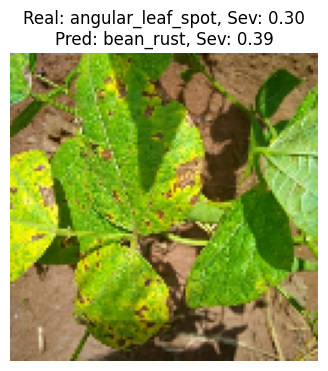

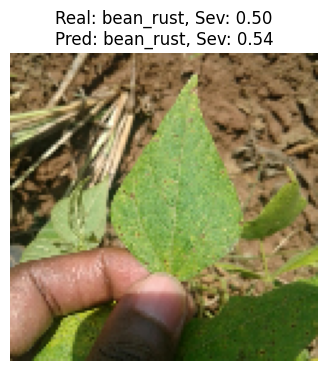

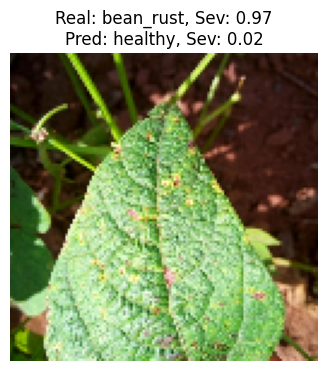

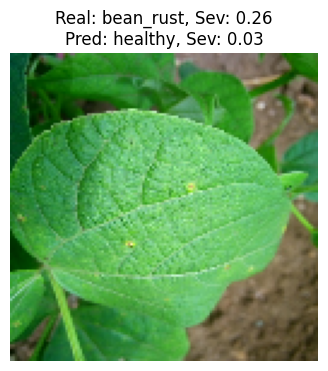

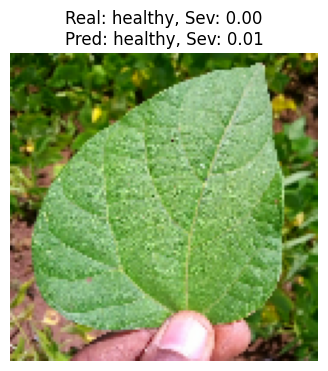

In [ ]:
# Re-compile the original model with the fine-tuned optimizer
multi_output_model.compile(
    optimizer=adam_optimizer_tuned,
    loss=losses,
    metrics=metrics
)

# Re-train the model
history_tuned = multi_output_model.fit(
    ds_train_augmented,
    validation_data=ds_val_multi,
    epochs=10,
    verbose=0 # Suppress verbose output for retraining
)

# Create a new dataset for visualization
ds_test_multi_viz = ds_test.map(generate_conditional_severity, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_multi_viz = ds_test_multi_viz.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)

# Get some predictions
for img, (label, severity) in ds_test_multi_viz.take(5):
    # Get the model's prediction
    class_pred, severity_pred = multi_output_model.predict(tf.expand_dims(img, axis=0), verbose=0)

    # Get the class with the highest probability
    predicted_class = np.argmax(class_pred[0])

    # Display the image and the results
    plt.figure(figsize=(4, 4))
    plt.imshow((img.numpy() * 255).astype("uint8"))
    plt.title(f"Real: {class_names[label.numpy()]}, Sev: {severity.numpy():.2f}\nPred: {class_names[predicted_class]}, Sev: {severity_pred[0][0]:.2f}")
    plt.axis('off')
    plt.show()

In [ ]:
# Save the fine-tuned model
multi_output_model.save('fine_tuned_model.h5')

# Print a confirmation message
print("Fine-tuned model saved successfully as fine_tuned_model.h5")